# [WORK IN PROGRESS] AM 207 project: final draft

## Zhai Yi, Andrew Merz, Cameron Clarke
## May 1, 2018

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import keras
import seaborn as sns
import pymc3 as pm
plt.style.use('seaborn')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


----

# Background and Math

## [TODO: Incorporate Zhai Yi's work]

-----

# Simulated data

In [3]:
xs = np.linspace(-1, 1, 500)
ys = -np.cos(xs)

train_mask = [False if i in range(200, 300)
              else True 
              for i in range(len(xs))]
test_mask = [not e for e in train_mask]

xs_train, ys_train = xs[train_mask], ys[train_mask]
xs_test, ys_test = xs[test_mask], ys[test_mask]

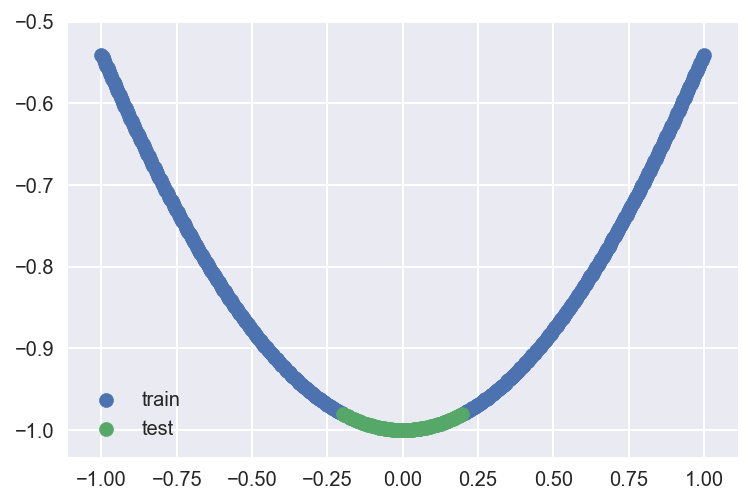

In [4]:
plt.scatter(xs_train, ys_train, label='train')
plt.scatter(xs_test, ys_test, label='test')
plt.legend();

-----

# Model architectures

In [5]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import SGD
import keras.backend as K
from keras.callbacks import Callback
from keras.callbacks import LearningRateScheduler

In [6]:
# Euclidean loss function--obtained from:
# http://www.riptutorial.com/keras/example/32022/euclidean-distance-loss
def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

# Implement learning rate schedule
# Adapted from examples at https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
def learning_schedule(epoch):
    base_lrate = 5e-3
    gamma = 0.0001
    p = 0.25
    lrate = base_lrate * (1 + gamma*140*epoch)**(-p)
    return lrate

# Code for NBatchLogger class borrowed from https://github.com/keras-team/keras/issues/2850
# from the comment by user wenmin-wu
class NBatchLogger(Callback):
    """
    A Logger that log average performance per `display` steps.
    """
    def __init__(self, display, num_xs):
        self.step = 0
        self.display = display
        self.metric_cache = {}
        self.num_xs = num_xs

    def on_batch_end(self, batch, logs={}):
        self.step += 1
        for k in self.params['metrics']:
            if k in logs:
                self.metric_cache[k] = self.metric_cache.get(k, 0) + logs[k]
        if self.step % self.display == 0:
            metrics_log = ''
            for (k, v) in self.metric_cache.items():
                val = v / self.display
                if abs(val) > 1e-3:
                    metrics_log += ' - %s: %.4f' % (k, val)
                else:
                    metrics_log += ' - %s: %.4e' % (k, val)
            print('iteration: {}... {}'.format(int(self.step/self.num_xs),
                                               metrics_log))
            self.metric_cache.clear()

### *No test-time Dropout*

In [7]:
# Create NN dropout model
def create_no_test_dropout_model():
    # Create model
    
    # model = Sequential()
    
    # inputs
    inputs = keras.Input(shape=(1,))
    
    # Layer 1
    layer_1 = Dense(100, kernel_initializer='lecun_uniform', activation='relu')(inputs)
    dropout_1 = Dropout(0.1)(layer_1, training=False)
   
    # Layer 2
    layer_2 = Dense(100, kernel_initializer='lecun_uniform', activation='relu')(dropout_1)
    dropout_2 = Dropout(0.1)(layer_2, training=False)
   
    # Layer 3
    layer_3 = Dense(100, kernel_initializer='lecun_uniform', activation='relu')(dropout_2)
    dropout_3 = Dropout(0.1)(layer_3, training=False)
   
    # Layer 4
    layer_4 = Dense(100, kernel_initializer='lecun_uniform', activation='relu')(dropout_3)
    dropout_4 = Dropout(0.1)(layer_4, training=False)
    
    # Layer 5
    outputs = Dense(1, input_dim=24, kernel_initializer='lecun_uniform')(dropout_4)
    
    # Compile model
    model = Model(inputs=inputs, outputs=outputs)
    sgd = SGD(lr=5e-3, momentum=0.9, decay=5e-7, nesterov=False)
    model.compile(loss=euclidean_distance_loss, optimizer=sgd)
    return model

### *With test-time dropout*

In [8]:
def create_model():
    # Create model
    
    # model = Sequential()
    
    # inputs
    inputs = keras.Input(shape=(1,))
    
    # Layer 1
    layer_1 = Dense(100, kernel_initializer='lecun_uniform', activation='relu')(inputs)
    dropout_1 = Dropout(0.1)(layer_1, training=True)
   
    # Layer 2
    layer_2 = Dense(100, kernel_initializer='lecun_uniform', activation='relu')(dropout_1)
    dropout_2 = Dropout(0.1)(layer_2, training=True)
   
    # Layer 3
    layer_3 = Dense(100, kernel_initializer='lecun_uniform', activation='relu')(dropout_2)
    dropout_3 = Dropout(0.1)(layer_3, training=True)
   
    # Layer 4
    layer_4 = Dense(100, kernel_initializer='lecun_uniform', activation='relu')(dropout_3)
    dropout_4 = Dropout(0.1)(layer_4, training=True)
    
    # Layer 5
    outputs = Dense(1, input_dim=24, kernel_initializer='lecun_uniform')(dropout_4)
    
    # Compile model
    model = Model(inputs=inputs, outputs=outputs)
    sgd = SGD(lr=5e-3, momentum=0.9, decay=5e-7, nesterov=False)
    model.compile(loss=euclidean_distance_loss, optimizer=sgd)
    return model

----

# Model runs

## NO TEST-TIME DROPOUT:

### Full data:

In [40]:
# nepochs = 700
# lrate = LearningRateScheduler(learning_schedule)
# out_batch = NBatchLogger(display=len(xs)*50, num_xs=len(xs))
# callbacks_list = [lrate, out_batch]

# sim_model_full = create_no_test_dropout_model()
# sim_model_full.fit(x=xs, y=ys, epochs=nepochs, batch_size=1, callbacks=callbacks_list, verbose=0)

iteration: 50...  - loss: 0.0284
iteration: 100...  - loss: 0.0202
iteration: 150...  - loss: 0.0178
iteration: 200...  - loss: 0.0163
iteration: 250...  - loss: 0.0149
iteration: 300...  - loss: 0.0139
iteration: 350...  - loss: 0.0131
iteration: 400...  - loss: 0.0129
iteration: 450...  - loss: 0.0123
iteration: 500...  - loss: 0.0116
iteration: 550...  - loss: 0.0115
iteration: 600...  - loss: 0.0111
iteration: 650...  - loss: 0.0107
iteration: 700...  - loss: 0.0102


In [41]:
ys_pred_full = sim_model_full.predict(xs)
ys_pred_full = ys_pred_full[:, 0]

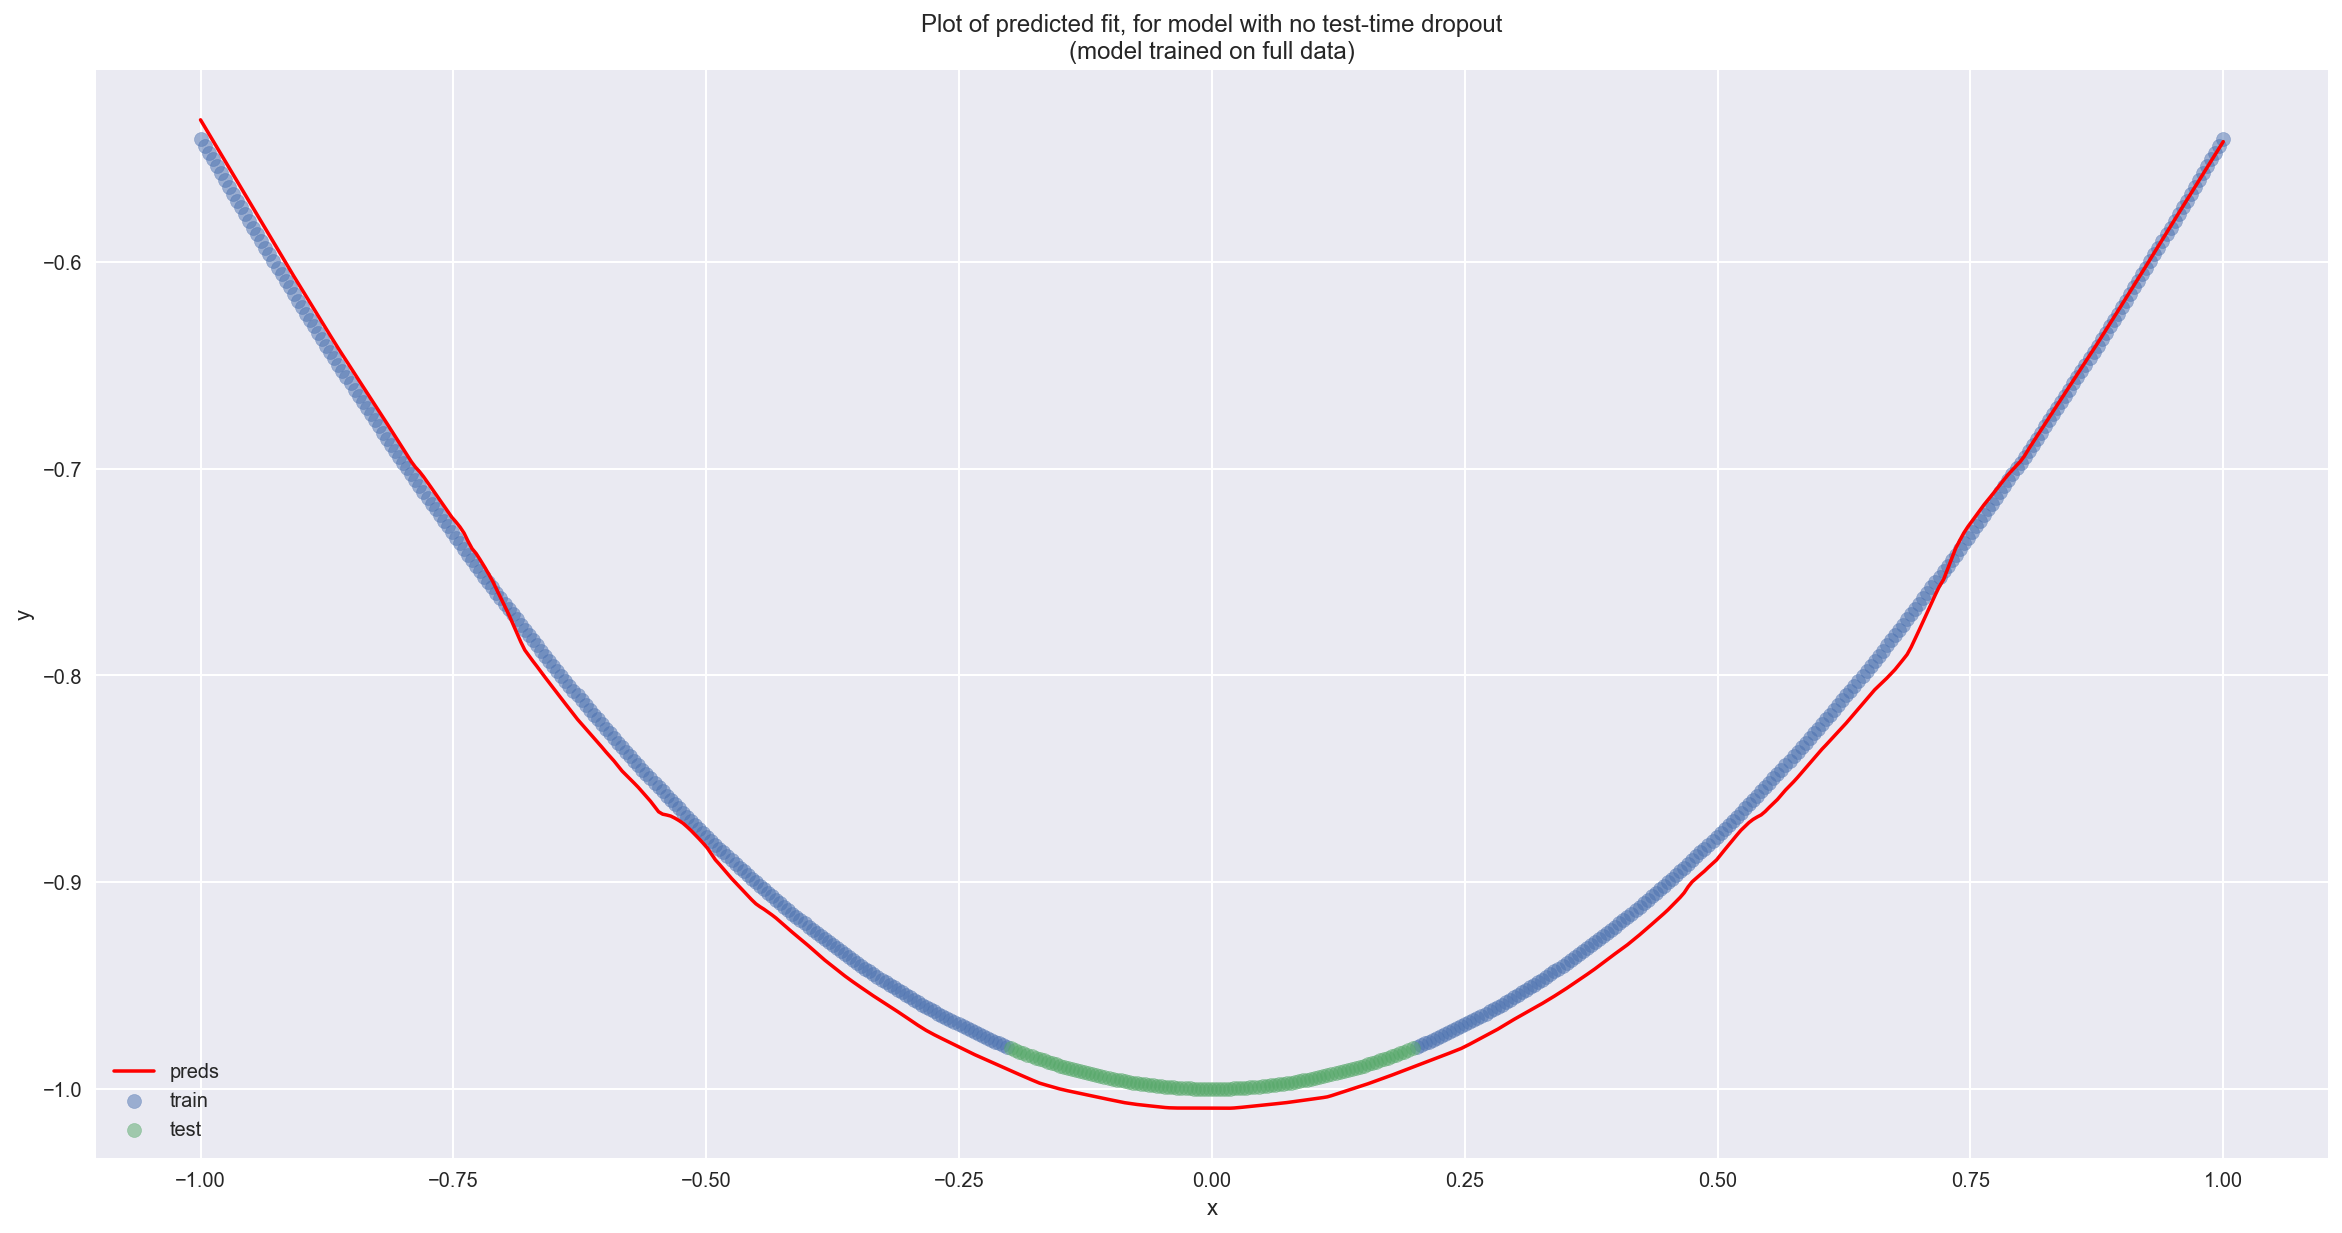

In [58]:
plt.style.use('seaborn')
plt.figure(figsize=(20,10))
plt.scatter(xs_train, ys_train, label='train', alpha=0.5)
plt.scatter(xs_test, ys_test, label='test', alpha=0.5)
plt.plot(xs, ys_pred_full, label='preds', c='r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of predicted fit, for model with no test-time dropout\n(model trained on full data)')
plt.legend()
plt.show()

### Training data only

In [44]:
# nepochs = 700
# lrate = LearningRateScheduler(learning_schedule)
# out_batch = NBatchLogger(display=len(xs_train)*50, num_xs=len(xs_train))
# callbacks_list_train = [lrate, out_batch]

# sim_model_train = create_no_test_dropout_model()
# sim_model_train.fit(x=xs_train, y=ys_train, epochs=nepochs, batch_size=1, callbacks=callbacks_list_train, verbose=0)

iteration: 50...  - loss: 0.0296
iteration: 100...  - loss: 0.0208
iteration: 150...  - loss: 0.0176
iteration: 200...  - loss: 0.0163
iteration: 250...  - loss: 0.0152
iteration: 300...  - loss: 0.0144
iteration: 350...  - loss: 0.0138
iteration: 400...  - loss: 0.0128
iteration: 450...  - loss: 0.0123
iteration: 500...  - loss: 0.0116
iteration: 550...  - loss: 0.0115
iteration: 600...  - loss: 0.0114
iteration: 650...  - loss: 0.0109
iteration: 700...  - loss: 0.0104


In [45]:
ys_pred_train = sim_model_train.predict(xs)
ys_pred_train = ys_pred_train[:, 0]

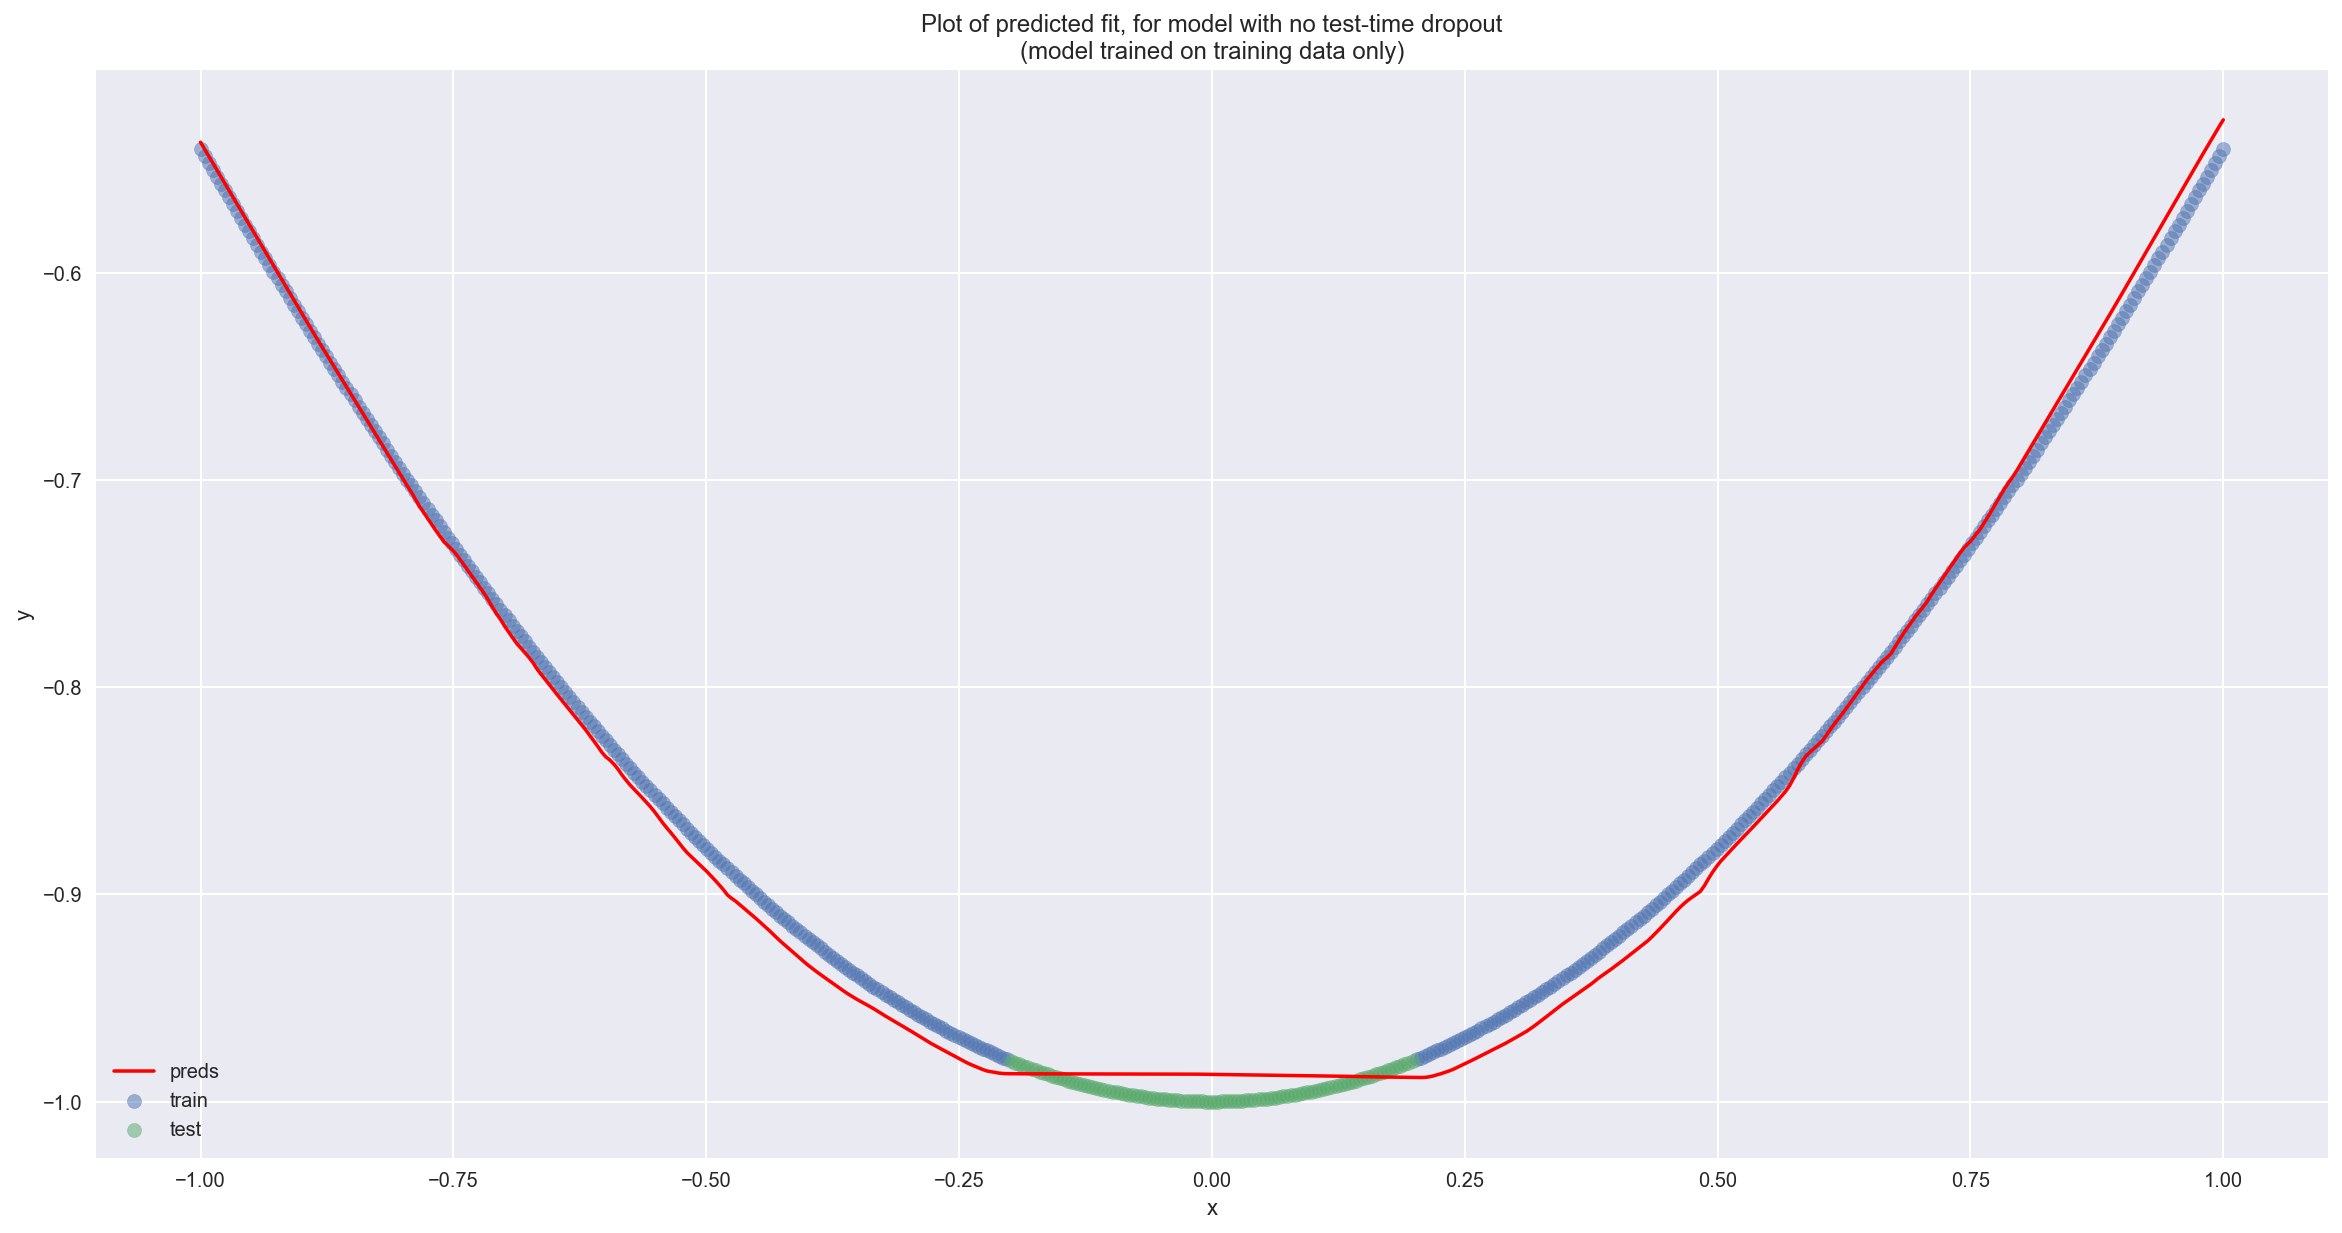

In [59]:
plt.style.use('seaborn')
plt.figure(figsize=(20,10))
plt.scatter(xs_train, ys_train, label='train', alpha=0.5)
plt.scatter(xs_test, ys_test, label='test', alpha=0.5)
plt.plot(xs, ys_pred_train, label='preds', c='r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of predicted fit, for model with no test-time dropout\n(model trained on training data only)')
plt.legend()
plt.show()

## WITH TEST-TIME DROPOUT

In [178]:
def plot_nn_results(ys_mean, ys_sd, full_data):
    plt.figure(figsize=(20,10))
    plt.scatter(xs_train, ys_train, label='train')
    plt.scatter(xs_test, ys_test, label='test')
    plt.plot(xs, ys_mean, label='predicted')
    plt.plot(xs, ys_mean + ys_sd, label='+ 1SD')
    plt.plot(xs, ys_mean - ys_sd, label='- 1SD')
    plt.fill_between(xs,
                     ys_mean - ys_sd,
                     ys_mean + ys_sd, 
                     color='green', alpha=0.3, label="two sigma envelope")
    plt.xlabel('x')
    plt.ylabel('y')
    
    if full_data:
        plt.title('Plot of distribution of predicted fit, for model with no test-time dropout\n(model trained on full data)')
    
    else:
        
        plt.title('Plot of distribution of predicted fit, for model with test-time dropout\n(model trained on training data only)')

    plt.legend()
    plt.show()

### Full data

In [173]:
# nepochs = 700
# lrate = LearningRateScheduler(learning_schedule)
# out_batch = NBatchLogger(display=len(xs)*50, num_xs=len(xs))
# callbacks_list_dropout_full = [lrate, out_batch]

# sim_model_dropout_full = create_model()
# sim_model_dropout_full.fit(x=xs, y=ys, epochs=nepochs, batch_size=1, callbacks=callbacks_list_dropout_full, verbose=0)

iteration: 50...  - loss: 0.0426
iteration: 100...  - loss: 0.0328
iteration: 150...  - loss: 0.0294
iteration: 200...  - loss: 0.0267
iteration: 250...  - loss: 0.0256
iteration: 300...  - loss: 0.0253
iteration: 350...  - loss: 0.0233
iteration: 400...  - loss: 0.0229
iteration: 450...  - loss: 0.0224
iteration: 500...  - loss: 0.0216
iteration: 550...  - loss: 0.0211
iteration: 600...  - loss: 0.0202
iteration: 650...  - loss: 0.0199
iteration: 700...  - loss: 0.0190


In [174]:
ys_pred_dropout_full = np.array([sim_model_dropout_full.predict(xs)[:, 0] for i in range(100)])
# length scale chosen below because cosine function has a period of 2*pi
l = 2*np.pi
p = 0.25
lambda_ = 5e-7
N_full = len(xs)
tau_full = (p * l**2/(2*N_full*lambda_))

ys_pred_dropout_full_mean = ys_pred_dropout_full.mean(axis=0)
ys_pred_dropout_train_sd = np.sqrt(tau_full**(-1) + ys_pred_dropout_full.var(axis=0))

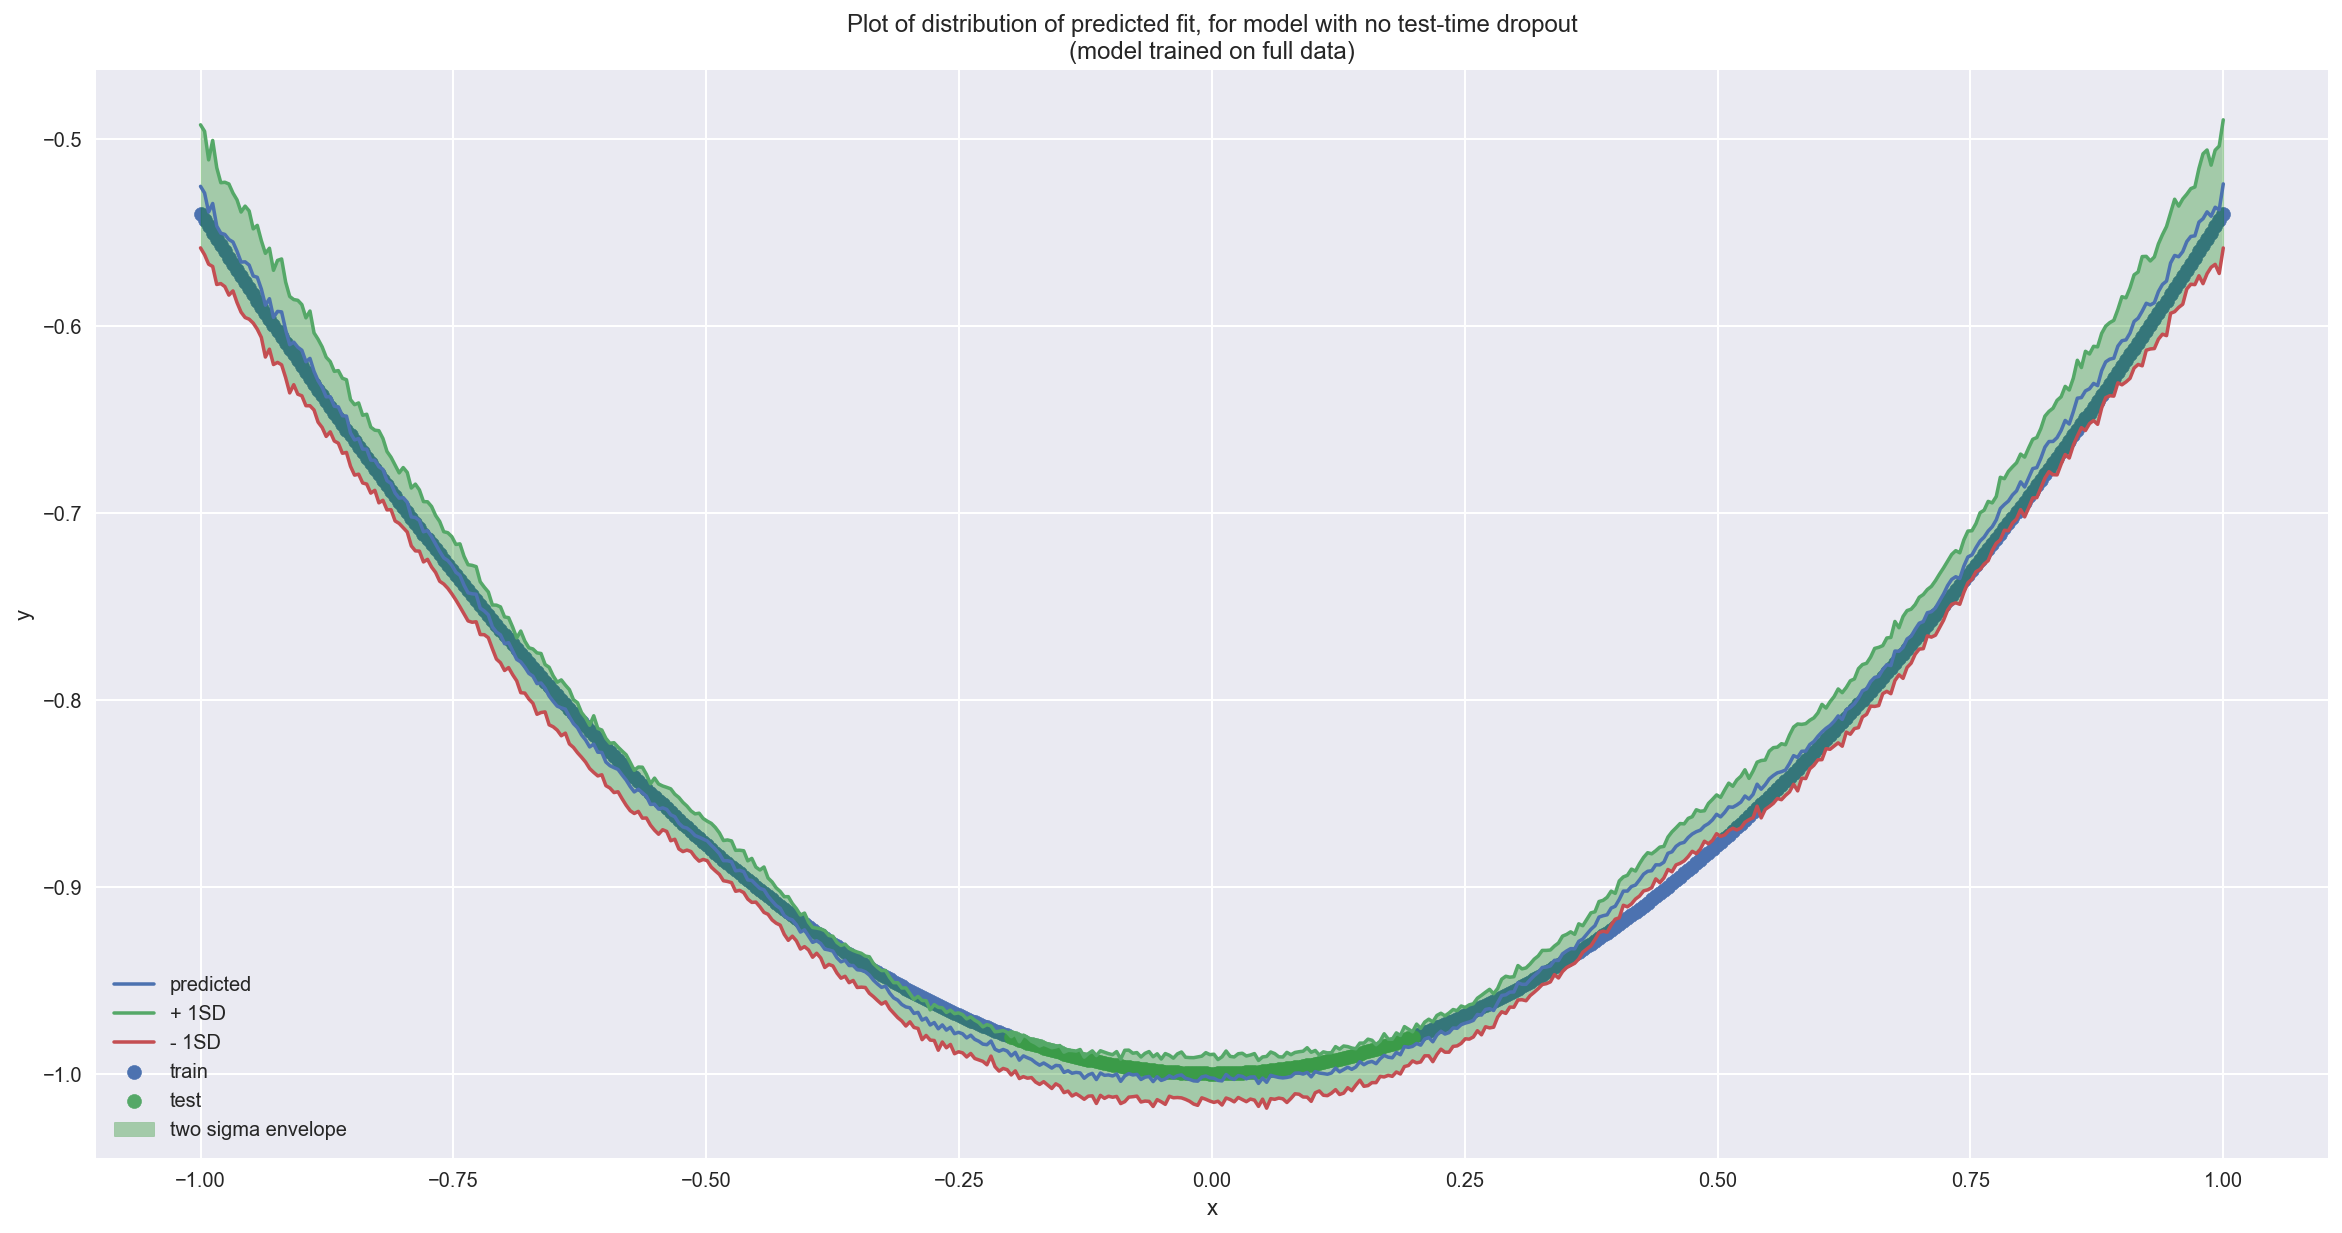

In [179]:
plot_nn_results(ys_pred_dropout_full_mean, ys_pred_dropout_full_sd, True)

### Training data only

In [127]:
# nepochs = 500
# lrate = LearningRateScheduler(learning_schedule)
# out_batch = NBatchLogger(display=len(xs_train)*50, num_xs=len(xs_train))
# callbacks_list_dropout_train = [lrate, out_batch]

# sim_model_dropout_train = create_model()
# sim_model_dropout_train.fit(x=xs_train, y=ys_train, epochs=nepochs, batch_size=1,
#                             callbacks=callbacks_list_dropout_train, verbose=0)

iteration: 50...  - loss: 0.0459
iteration: 100...  - loss: 0.0336
iteration: 150...  - loss: 0.0301
iteration: 200...  - loss: 0.0280
iteration: 250...  - loss: 0.0265
iteration: 300...  - loss: 0.0250
iteration: 350...  - loss: 0.0236
iteration: 400...  - loss: 0.0226
iteration: 450...  - loss: 0.0218
iteration: 500...  - loss: 0.0212


In [168]:
ys_pred_dropout_train = np.array([sim_model_dropout_train.predict(xs)[:, 0] for i in range(100)])

# length scale chosen below because cosine function has a period of 2*pi
l = 2*np.pi
p = 0.25
lambda_ = 5e-7
N_train = len(xs_train)
tau_train = (p * l**2/(2*N_train*lambda_))

ys_pred_dropout_train_mean = ys_pred_dropout_train.mean(axis=0)
ys_pred_dropout_train_sd = np.sqrt(tau_train**(-1) + ys_pred_dropout_train.var(axis=0))

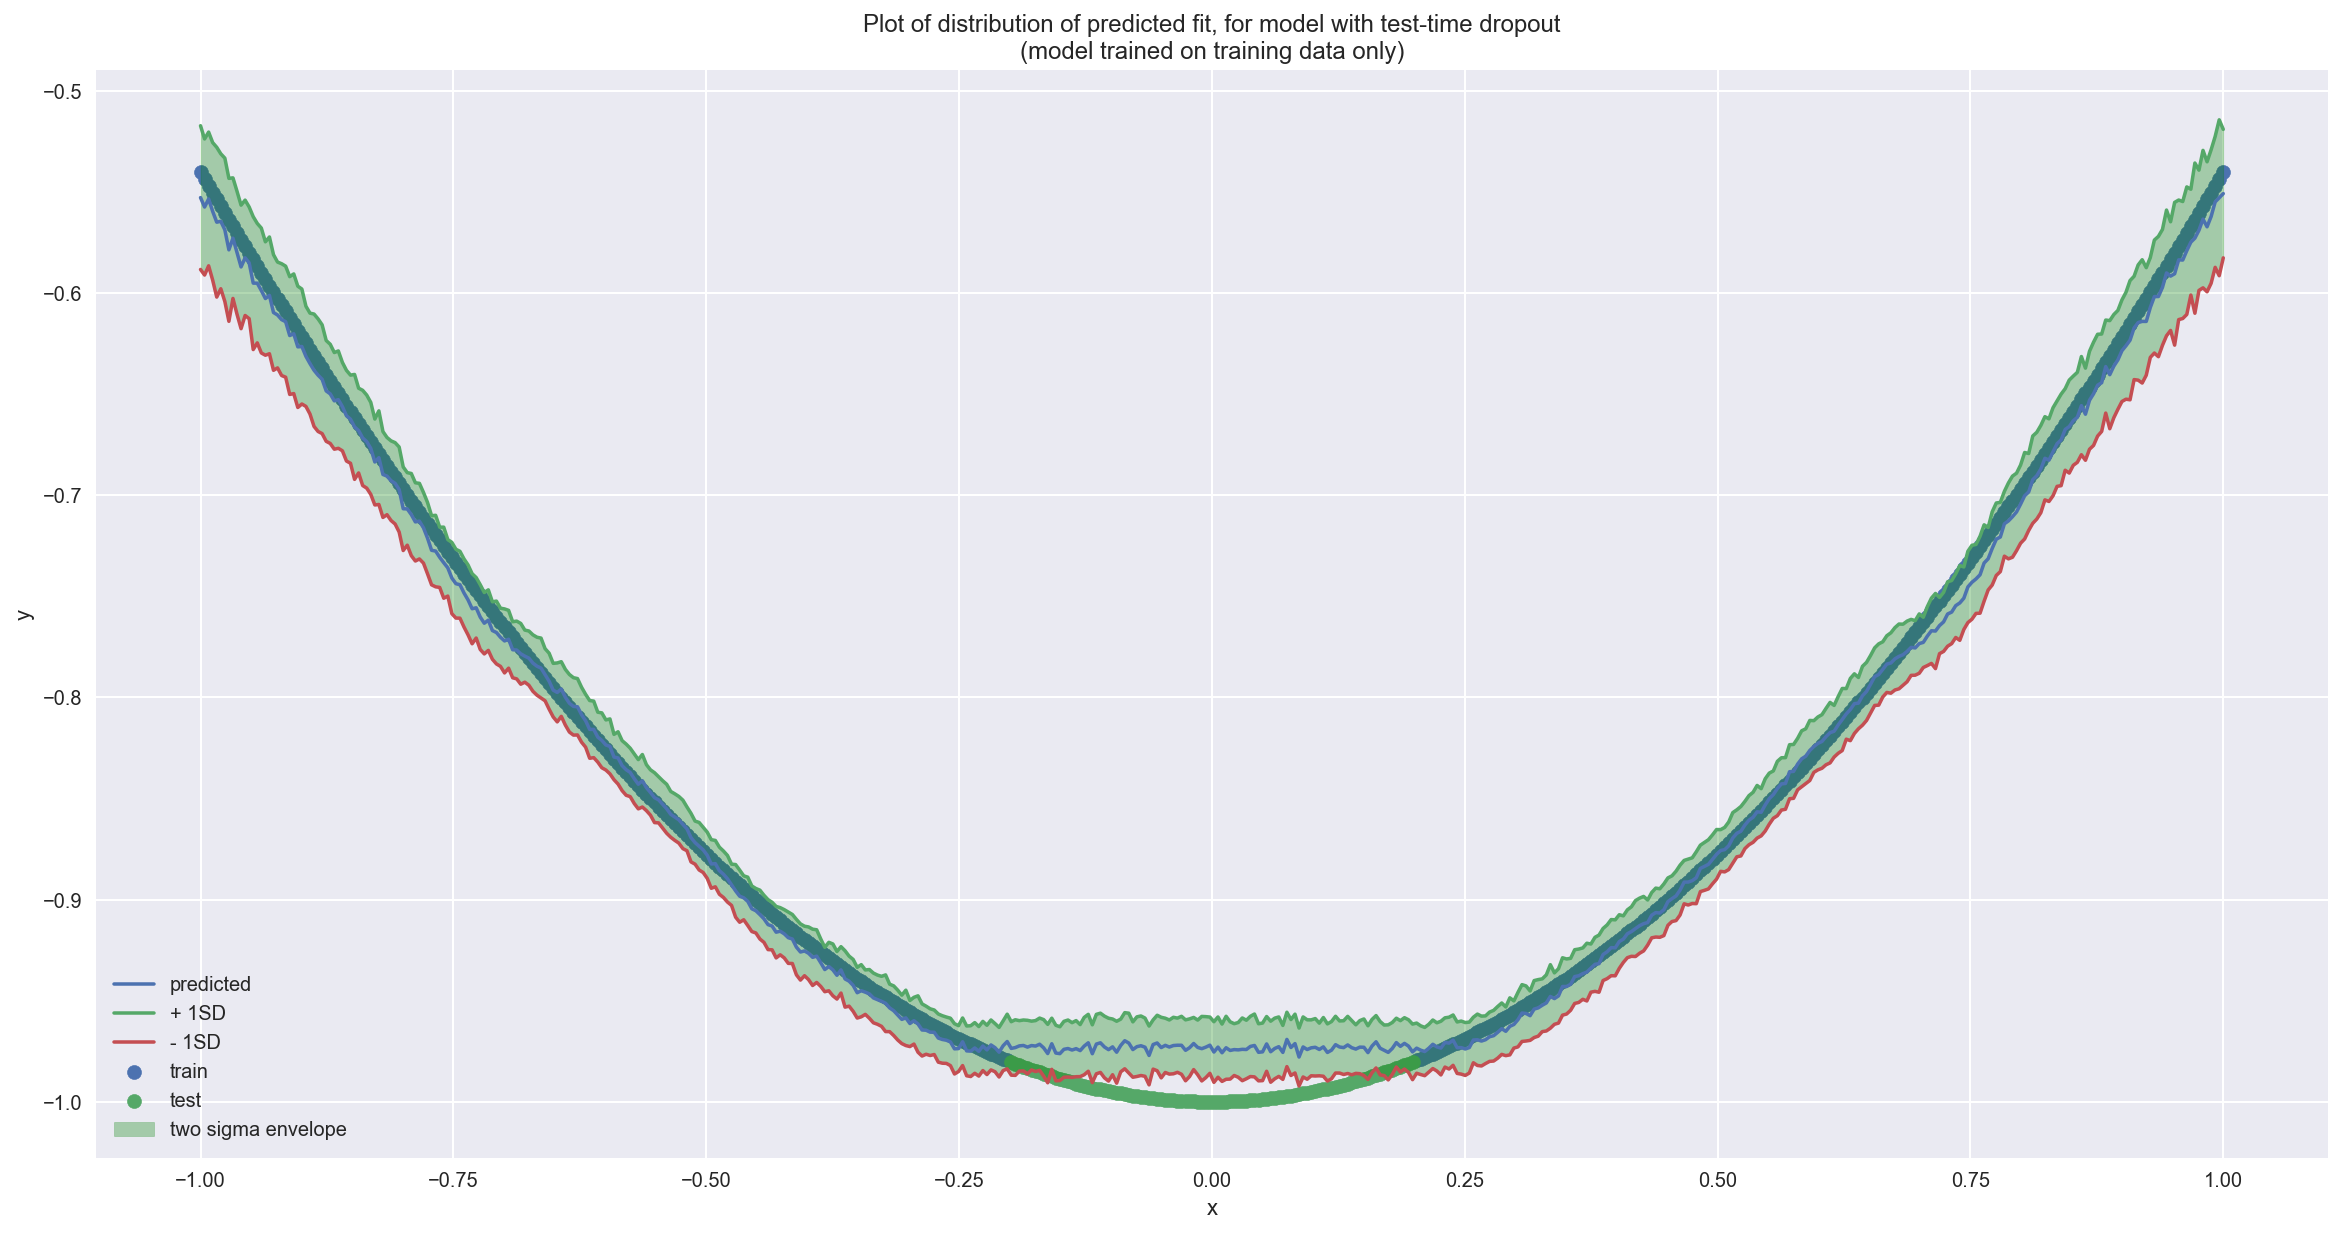

In [180]:
plot_nn_results(ys_pred_dropout_train_mean, ys_pred_dropout_train_sd, False)